### **RGB Image Classification Capstone Project**

In [126]:
''' Import all Important Libraries '''
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [127]:
torch.manual_seed(50)
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device :',Device)

Using Device : cpu


### **Data Pipeline**

In [128]:
Transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5))
    ])

In [129]:
class CIFAR10Dataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
        )
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
            return image, label

In [130]:
Train_dataset = CIFAR10Dataset(train=True, transform=Transformation)
Test_dataset = CIFAR10Dataset(train=False, transform=Transformation)
print(len(Train_dataset))
print(len(Test_dataset))

50000
10000


In [131]:
example_image, example_label = Train_dataset[0]
print(f'image shape:{example_image.shape}\n label shape:{Train_dataset.classes[example_label]}')

image shape:torch.Size([3, 32, 32])
 label shape:frog


### **Train, Test DataLoader**

In [132]:
Train_DataLoader = DataLoader(
    dataset=Train_dataset,
    batch_size=32,
    shuffle=True
)

Test_DataLoader = DataLoader(
    dataset=Test_dataset,
    batch_size=32,
    shuffle=True
)

### ***Convo > Pooling > Relu > Linear > Flatten***

In [133]:
class MyImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.pooling = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            padding=1
        )

        self.Linear1 = nn.Linear(32 * 8 * 8, 256)
        self.Linear2 = nn.Linear(256, 10)


    def forward(self, x):
        # First conv Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)

        # Second Conv Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)

        # Flatten
        x = x.view(-1, 32 * 8 * 8)
        x = self.Linear1(x) # Layer 1
        x = self.relu(x)

        x = self.Linear2(x) # Layer 2

        return x

In [134]:
Model = MyImageNet().to(Device)
print(Model)

MyImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear1): Linear(in_features=2048, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=10, bias=True)
)


### **Train Model**

100%|██████████| 1563/1563 [00:12<00:00, 128.03it/s]


Epoch 1/5 Loss: 1.356


100%|██████████| 1563/1563 [00:12<00:00, 128.47it/s]


Epoch 2/5 Loss: 1.003


100%|██████████| 1563/1563 [00:12<00:00, 126.56it/s]


Epoch 3/5 Loss: 0.841


100%|██████████| 1563/1563 [00:12<00:00, 128.02it/s]


Epoch 4/5 Loss: 0.715


100%|██████████| 1563/1563 [00:12<00:00, 126.51it/s]


Epoch 5/5 Loss: 0.602


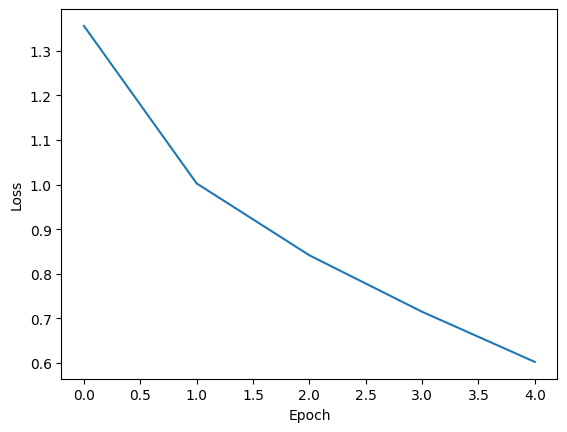

In [135]:
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)
num_epochs =5
criterion_losses = []
for epoch in range(num_epochs):
    Model.train() # Train Model
    batch=1
    running_loss = 0.0
    for images, label in tqdm(Train_DataLoader):
        images, label = images.to(Device), label.to(Device)
        batch += 1
        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(Train_DataLoader)
    criterion_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs} Loss: {epoch_loss:.3f}')

import matplotlib.pyplot as plt
plt.plot(criterion_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()